In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# variables
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5
delta_t = 60
sigma_uere = 0 # can't find a value for this

In [3]:
h_0 = 1.4*(10**(-22))
h_m1 = 2.3*(10**(-26))
h_m2 = 3.3*(10**(-31))

dt = 60

pi = math.pi

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*((pi*h_m2*dt)**2)*dt
e2 = h_m1*dt + h_m2*(pi*dt)**2
e3 = (h_0/(2*dt))+ 4*h_m1 + (8/3)*(pi*pi)*h_m2*dt

Q = np.array([[e1,e2],[e2,e3]])
print(Q)

[[4.36560000e-21 1.39172509e-24]
 [1.39172509e-24 1.25918778e-24]]


In [4]:
s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
prr_var = ((c**2)/((2*pi*f_L1 * T_c)**2)) * (s_pll)


# R = lambda N :np.block([[pr_var*np.eye(N,N),np.zeros((N,N))],[np.zeros((N,N)),prr_var*np.eye(N,N)]])
R = lambda N :np.eye(2*N,2*N)

print(R(2))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [5]:
class Station:
    def __init__(self,id):
        self.local_time = None
        self.global_est = 0 #\hat{T}_g,n
        self.id = id
        self.x = None
        self.P = None
        self.psi_n = None
        self.nbhrs = []
        self.nbhr_dist = {}

    def time_update(self, Q,delta_t = 60):
        # time update steps
        A = np.array([[1, delta_t], [0, 1]])
        self.x = A @ self.x
        self.P = A @ self.P @ A.T + Q

    def incremental_update(self,R,z):
    # Calculate pseudorange/range-rate residuals using Eqs. (23)-(25), add in speed of light
        N = int(len(z)/2)

        C = np.block([
                [np.ones((N, 1)), np.zeros((N, 1))],
                [np.zeros((N, 1)), np.ones((N, 1))]
            ])

        # Update the state and covariance estimate with Eqs. (26)-(28)
        K_n = self.P @ C.T @ np.linalg.inv(C @ self.P @ C.T + R(N)) # Kalman gain matrix; R defined earlier
        x_hat_n = self.x + K_n @ (z - C @ self.x)
        P_hat_n = (np.eye(len(self.x)) - K_n @ C) @ self.P
        self.x = x_hat_n
        self.P = P_hat_n

    def crosslink_update(self,nbhr_time_ests,nbhr_cov_ests):
        H = np.array([[1, 0]])
        self.psi_n = np.copy(self.x)
        P_hat_n = self.P
        
        for nbhr in self.nbhrs:
            #This is temporary! Need to better sync whole timing
            z_jB = c*(self.local_time["B"]-nbhr_time_ests[nbhr.id] - self.nbhr_dist[nbhr.id])
            z_jn = np.array([[z_jB + self.x[1][0]*(self.local_time["n"] - self.local_time["B"])]])
            print("z_jn: ",z_jn)
            d_tilde = 0.01
            R_j = np.array([[d_tilde + nbhr_cov_ests[nbhr.id][0][0]]])

            K_ij_n = self.P @ H.T @ np.linalg.inv(H @ self.P @ H.T + R_j)
            self.psi_n = self.psi_n + (K_ij_n @ (z_jn - H @ self.psi_n))
            P_hat_n = (np.eye(2) - K_ij_n @ H) @ P_hat_n
        
        self.P = P_hat_n    
    def second_cross_link(self,D_ij):
        return self.local_time["n"] - ((1/c)*self.psi_n[0][0]) + D_ij

    def diffusion_update(self,B,nbhr_time_est):
        my_T_hat_g_n = self.local_time["n"] - (1/c)*self.psi_n[0][0]

        T_hat_g_n = {nbhr.id:nbhr_time_est[nbhr.id]+(1-(self.x[1][0]/c))*(self.local_time['n'] - self.local_time['Bp']) for nbhr in self.nbhrs}
        
        self.global_est = sum([B[self.id][nbhr.id]*T_hat_g_n[nbhr.id] for nbhr in self.nbhrs]+[B[self.id][self.id]*my_T_hat_g_n])
        self.x = np.array([[c*(self.local_time["n"] - self.global_est)],self.x[1]])

In [6]:
import time

def measurement_noise(R,N_i):
     return np.linalg.cholesky(R(N_i))@np.random.normal(np.array([[0 for _ in range(2*N_i)]]).T)

def GPS_measurements(true_bias, true_drift,R,N_i = 2):

     true_pr = np.array([[c*(true_bias[0])] for _ in range(N_i)])

     true_prr = np.array([[c*(true_drift[0])] for _ in range(N_i)])

     true_measurements = np.vstack((true_pr,true_prr))

     return true_measurements+measurement_noise(R,N_i)

In [7]:
def filter_initialize(stations,adj_mat,x_initial,P_initial):
  M = len(stations)
  for i in range(M):
    stations[i].x = x_initial[i]
    stations[i].P = P_initial[i]

    for j in range(i+1,M):
        if adj_mat[i][j]!=0:
          stations[i].nbhrs.append(stations[j])
          stations[j].nbhrs.append(stations[i])
          stations[i].nbhr_dist[j] = adj_mat[i][j]
          stations[j].nbhr_dist[i] = adj_mat[i][j]

def new_local_times(true_time,true_bias,true_drift):
   T_A = true_time+true_bias
   T_B = T_A+3+(true_drift*3)
   T_n = T_B
   T_Bp = T_n+3+(true_drift*3)

   return {'A':T_A,'B':T_B,'n':T_n,'Bp':T_Bp}


def diffusion_filter_iteration(stations,Q,R,diff_weights, true_bias, true_drift,true_time,dt,N=None):
    if N is None: N = [2 for _ in range(len(stations))]

    #share first_cross_link

    measurements = []

    for station in stations:
      station.local_time = new_local_times(true_time,true_bias[station.id][0],true_drift[station.id][0])
      time_ests_A = {nbhr.id:nbhr.global_est for nbhr in station.nbhrs}
      cov_ests_A = {nbhr.id:nbhr.P for nbhr in station.nbhrs}

      # time update step
      station.time_update(Q,delta_t = dt)

      z = GPS_measurements(true_bias[station.id],true_drift[station.id],R,N[station.id])
      measurements.append(z)
      station.incremental_update(R,z)

      # initialize psi_n with x from step 2 (can choose from step 1 or 2)
      print("T_gA: ",time_ests_A)
      station.crosslink_update(time_ests_A,cov_ests_A)

    for station in stations:
      time_ests_Bp = {nbhr.id:nbhr.second_cross_link(station.nbhr_dist[nbhr.id]) for nbhr in station.nbhrs}
      station.diffusion_update(diff_weights, time_ests_Bp)
      station.global_est += 3
    print("----------------------------")
    return measurements

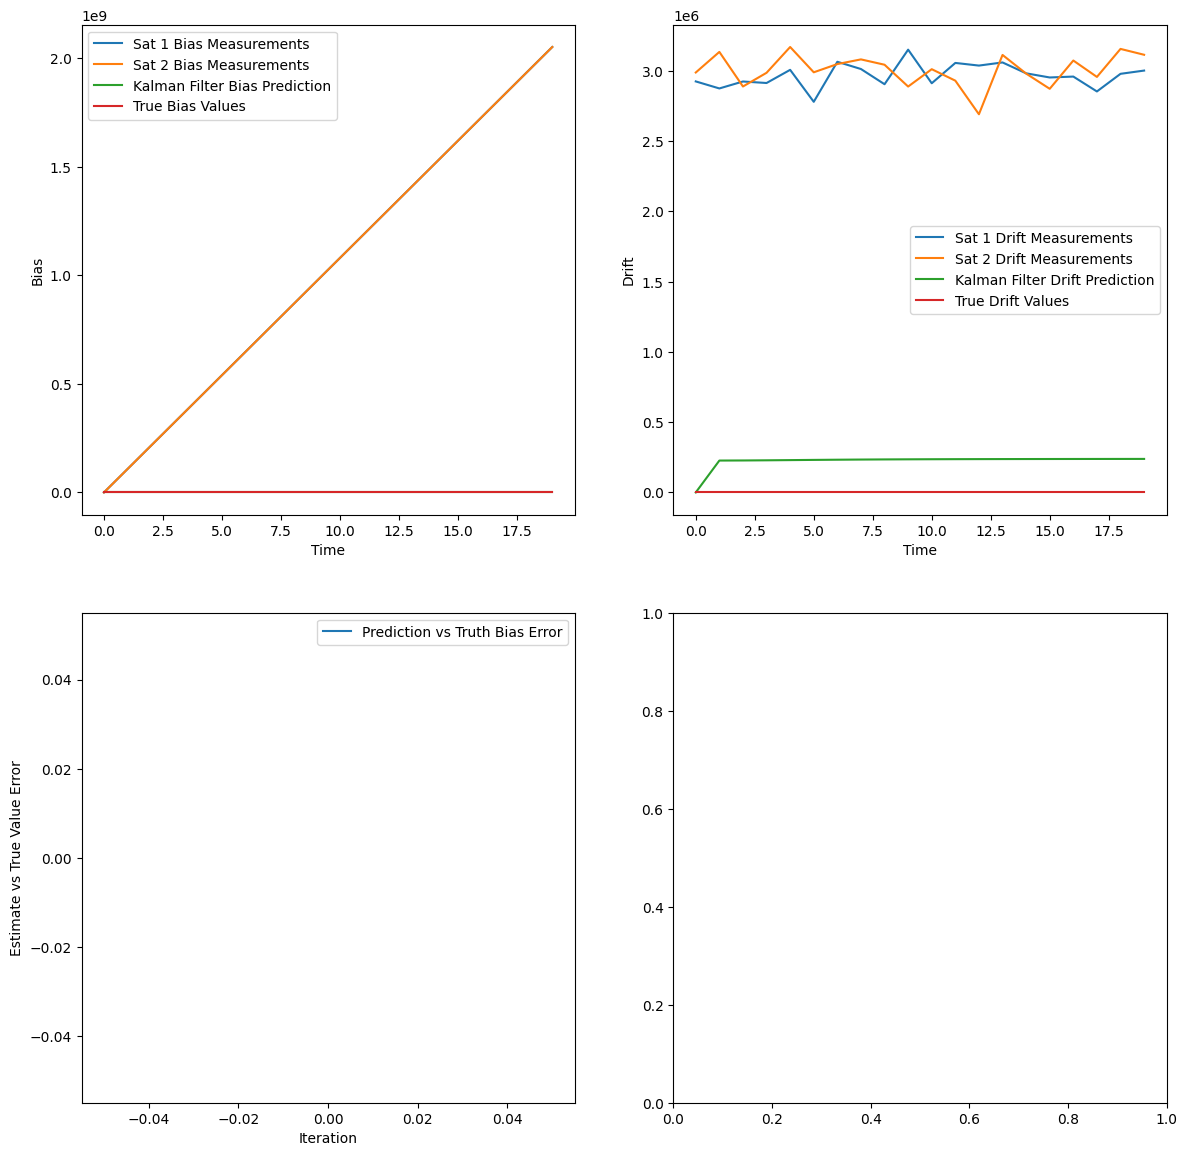

In [8]:

C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])
n = len(C[0])

# true initial state

dt = 6

T_g = 0
true_biases = np.array([[0, 0.1, 0, 0, -0.2]]).T
true_drifts = np.array([[0,0,0,0,0]]).T

x = c*np.vstack((true_biases,true_drifts))

# random initial estimates for each node

x0 = [np.array([[x[i][0]],[x[i+n][0]]]) for i in range(n)]
# x0 = [np.array([[0],[0]]) for _ in range(5)]

P = [np.eye(2) for _ in range(n)]

#Process Noise
procc_noise = lambda : np.linalg.cholesky(Q) @ np.random.normal(np.array([[0,0]]).T)

truth = []
measurements = []
predictions = []
errors = []

stations = [Station(i) for i in range(n)]

filter_initialize(stations,D,x0,P)

iterations = 40

for i in range(iterations):
    true_biases = [x[:n][i]/c for i in range(n)]
    true_drifts = [x[n:][i]/c for i in range(n)]
    measures = diffusion_filter_iteration(stations,Q,R,C,true_biases,true_drifts,T_g,dt)
    errors.append([station.global_est - (T_g) for station in stations])
    truth.append(x)
    measurements.append(measures)
    predictions.append([stn.x for stn in stations])
    print("Station 2 check: ",(stations[1].x,x[1]))
    noise = np.array([procc_noise().T[0] for _ in range(n)])
    formatted_noise = np.vstack((np.array([noise[:,0]]).T,np.array([noise[:,1]]).T))

    x = np.array([[1,0,0,0,0,dt,0,0,0,0],[0,1,0,0,0,0,dt,0,0,0],[0,0,1,0,0,0,0,dt,0,0],
                  [0,0,0,1,0,0,0,0,dt,0],[0,0,0,0,1,0,0,0,0,dt],[0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1]])@x + formatted_noise
    T_g += 6

fig,axs = plt.subplots(3,2, figsize=(14, 21))
#12 plots, 5 for bias, 5 for drift, and then error
for i in range(5):
    #20 measurements, 2 for each node
    axs[i//2][i%2].plot([i for i in range(iterations)],[x[i][0][0] for x in measurements], label = 'Sat 1 Bias Measurements')
    axs[i//2][i%2].plot([i for i in range(iterations)],[x[i][1][0] for x in measurements], label = 'Sat 2 Bias Measurements')
    axs[i//2][i%2].plot([i for i in range(iterations)],[x[i][0][0] for x in predictions], label = 'Kalman Filter Bias Prediction')
    axs[i//2][i%2].plot([i for i in range(iterations)],[x[i][0] for x in truth], label = 'True Bias Values')
    axs[i//2][i%2].set_xlabel("Time")
    axs[i//2][i%2].set_ylabel("Bias")
    axs[i//2][i%2].legend()

    # axs[0][1].plot([i for i in range(iterations)],[x[i][2][0] for x in measurements], label = 'Sat 1 Drift Measurements')
    # axs[0][1].plot([i for i in range(iterations)],[x[i][3][0] for x in measurements], label = 'Sat 2 Drift Measurements')
    # axs[0][1].plot([i for i in range(iterations)],[x[i][1][0] for x in predictions], label = 'Kalman Filter Drift Prediction')
    # axs[0][1].plot([i for i in range(iterations)],[x[i+n][0] for x in truth], label = 'True Drift Values')
    # axs[0][1].set_xlabel("Time")
    # axs[0][1].set_ylabel("Drift")
    # axs[0][1].legend()

    axs[2][1].plot([i for i in range(len(errors))],[x[i] for x in errors], label = 'Prediction vs Truth Bias Error at Stn '+str(i))

axs[2][1].legend()
axs[2][1].set_xlabel("Iteration")
axs[2][1].set_ylabel("Estimate vs True Value Error")
plt.show()

